# Load Default imports

In [1]:
import os 
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()
import numpy as np

## Declare Two Class

In [2]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model 

#define class mnist clasification model with out top 
class Mnist_with_out_top(tf.keras.Model):
    def __init__(self):
        super(Mnist_with_out_top, self).__init__()
        self.conv1 = layers.Conv2D(16,[3,3], activation='relu')
        self.conv2 = layers.Conv2D(16,[3,3], activation='relu')
        self.conv3 = layers.Conv2D(16,[3,3], activation='relu')
        self.flat = layers.Flatten()
        
    
    def __call__(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flat(x)
        return x
    
#define class mnist classification with pretain
class Mnist_with_Pretrain(tf.keras.Model):
    def __init__(self, pretrain):
        super(Mnist_with_Pretrain, self).__init__()
        self.pretrain = pretrain
        self.pretrain.trainable = False
        self.dense = layers.Dense(10)
    
    def __call__(self, x):
        x = self.pretrain(x)
        x = self.dense(x)
        return x

---
Mnist with out top model output is 7744(dense)
---

In [3]:
model = Mnist_with_out_top()
x = tf.random_normal([1,28,28,1])
print(model(x).shape)

(1, 7744)


### Load trained weights from cpk 

In [4]:
tfe.Saver((model.variables)).restore("./model/mnist.cpk")

INFO:tensorflow:Restoring parameters from ./model/mnist.cpk


overload Class

In [5]:
new_model = Mnist_with_Pretrain(model)
print(new_model(x).shape)
optimizer = tf.train.AdamOptimizer()

(1, 10)


### check trainable 

In [6]:
for i, layer in enumerate(new_model.layers):
    print("{} th layer trainable : {}".format(i, layer.trainable))

0 th layer trainable : False
1 th layer trainable : True


In [7]:
print("variables:{}".format(len(new_model.variables)))
print("train_variables:{}".format(len(new_model.trainable_variables)))

variables:8
train_variables:2


# Load Dataset

In [8]:
# Fetch and format the mnist data
mnist = tf.keras.datasets.mnist
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

### train Model

In [9]:
device = '/cpu:0' if tfe.num_gpus() == 0 else '/gpu:0'
print('using device %s' %device)
epoch=2
loss_history = []
acc_history = []
iteration = 0
with tf.device(device):  
    for _ in range(epoch):
        for ( batch, (images, labels)) in enumerate(dataset.take(6000)):
            accuracy = tfe.metrics.Accuracy('accuracy', dtype=tf.float32)
            with tf.GradientTape() as tape:
                logits = new_model(images)
                loss_value = tf.losses.sparse_softmax_cross_entropy(labels, logits)
                accuracy(tf.argmax(logits, axis=1, output_type=tf.int64),
                        tf.cast(labels, tf.int64))

            loss_history.append(loss_value.numpy())
            acc_history.append(accuracy.result())
            #in pretrain mode 
            #when calculate grds, use only new_model.trainable_variables not 
            #new_model.all_variables 
            grads = tape.gradient(loss_value, new_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, new_model.trainable_variables), 
                                     global_step=tf.train.get_or_create_global_step())
            if (iteration % 20)== 0 :
                print("Loss at step {:03d}: {:.3f}, Accu : {:.3f}".format(iteration, loss_value, accuracy.result()))
            if accuracy.result() > 0.95 :
                break
            iteration = iteration + 1
print("Loss at step {:03d}: {:.3f}, Accu : {:.3f}".format(iteration, loss_value, accuracy.result()))       


using device /gpu:0
Loss at step 000: 2.407, Accu : 0.000
Loss at step 020: 0.721, Accu : 0.781
Loss at step 030: 0.299, Accu : 0.969


In [10]:
import pandas as pd
loss_history = pd.DataFrame(loss_history)
acc_history = pd.DataFrame(acc_history)

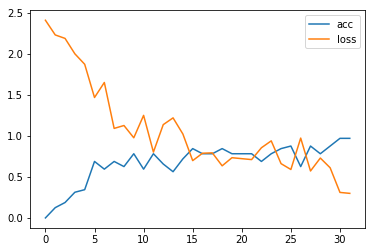

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(acc_history, label='acc')
plt.plot(loss_history, label='loss')
plt.legend()